# Introduction to Differential Privacy

Differential Privacy (DP) is a framework for quantifying the privacy leakage from statistical databases. It provides strong guarantees that the output of a database query does not allow one to infer much about any single individual's data in the database or whether any individual person or entity existed in the dataset in the first place. Here, we introduce the mathematical foundations of DP, followed by practical demonstrations of key concepts with AGENT.


## Differential Privacy: Definitions and Equations

Formally, a randomized algorithm $\mathcal{A}$ provides $\epsilon$-differential privacy if for all datasets $D$ and $D'$ that differ on a single element, and for all $S$ in the output space of $\mathcal{A}$,

$$
Pr[\mathcal{A}(D) \in S] \leq e^\epsilon Pr[\mathcal{A}(D') \in S]
$$

Here, $\epsilon$ is a non-negative parameter that quantifies the privacy guarantee: smaller values mean more privacy.


## Introducing the Laplace Mechanism

The Laplace mechanism is a fundamental tool in differential privacy used to add noise to the output of a function to protect individuals' privacy. It relies on the Laplace distribution, characterized by its scale parameter, which is determined by the sensitivity of the function and the desired level of privacy ($\epsilon$).

### Sensitivity

The sensitivity of a function quantifies the maximum amount of change one individual's data can have on the output of the function. For a numerical function $f$, the sensitivity, denoted as $\Delta f$, is defined as:

$$
\Delta f = \max_{D, D'} ||f(D) - f(D')||_1
$$

where $D$ and $D'$ are any two datasets that differ by at most one individual.

### Laplace Distribution and Mechanism

The Laplace distribution is used to generate noise that is added to the true output of the function. The probability density function of the Laplace distribution centered at 0 with scale $\lambda$ is:

$$
P(x | \lambda) = \frac{1}{2\lambda} \exp\left(-\frac{|x|}{\lambda}\right)
$$

The scale parameter $\lambda$ is set to $\frac{\Delta f }{\epsilon}$, aligning the amount of noise with the sensitivity of the function and the privacy parameter $\epsilon$.

### Expected Error

Of course, introducing noise to a query will cause some error. It is worth while being able to quatify how much error. Fortunately, the standard error of Laplace noise has a very simple form as $\sqrt{2}\lambda = \sqrt{2}\frac{Δf}{\epsilon}$. Remember this is absolute error, not relative, so for large datasets the error can be very small, but for tiny datasets it may be large.

### Privacy Budgets

$\epsilon$-Differential Privacy, as defined above, and it's counter part $(\epsilon, \delta)$-Differential Privacy (which simply means that $\epsilon$-Differential Privacy is achieved with probability $1 - \delta$) have some very nice properties.

From the perspective of budgeting both $\epsilon$ and $\delta$ are additive over multiple queries. So if you make $k$ queries using $(\epsilon_1, \delta_1), (\epsilon_2, \delta_2), (\epsilon_3, \delta_3), \dots$ the total privacy loss is less than or equal to $(\sum_{i=1}^{k} \epsilon_i, \sum_{i=1}^{k} \delta_i)$.

This nice property allows us to limit users access to a dataset based on a limitation of the total privacy loss incurred over their queries. We refer to this as their Privacy Budget and this concept is core to AGENT's data access provisioning.


### Visualizing the Laplace Mechanism

There are a number of ways we can visualize the Laplace mechanism, but possibly the most straight forward is simply to plot the distribution of observing an outcome of a summation given two datasets differing by one data point:

1000
999


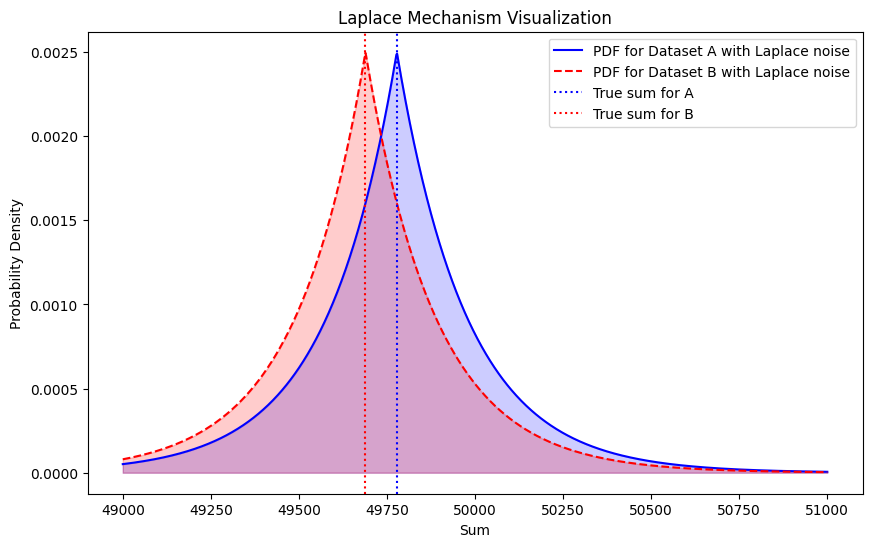

In [ ]:
# This is not secure DP, please use this as an illustration only
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import laplace

# Sensitivity of the sum function is the maximum possible difference in the sum caused by one individual, which is 5 here.

epsilon = 0.5  # Privacy budget
scale = 100 / epsilon  # Scale parameter for Laplace distribution


# Two datasets differing by one row (entity)
dataset_A = np.random.randint(0, 100, 1000)
print(len(dataset_A))
dataset_B = dataset_A[:-1]
print(len(dataset_B))

# Recalculating the true sums without adding noise yet for clarity in plotting
true_sum_A = np.sum(dataset_A)  # True sum of dataset A
true_sum_B = np.sum(dataset_B)  # True sum of dataset B

# Generating points for the PDFs
x = np.linspace(49000, 51000, 1000)

# Calculating the PDFs for the true sums with added Laplace noise
pdf_A = laplace.pdf(x, loc=true_sum_A, scale=scale)
pdf_B = laplace.pdf(x, loc=true_sum_B, scale=scale)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x, pdf_A, label='PDF for Dataset A with Laplace noise', color='blue')
plt.fill_between(x, pdf_A, color='blue', alpha=0.2)
plt.plot(x, pdf_B, label="PDF for Dataset B with Laplace noise", color='red', linestyle='--')
plt.fill_between(x, pdf_B, color='red', alpha=0.2)
plt.axvline(x=true_sum_A, color='blue', linestyle=':', label='True sum for A')
plt.axvline(x=true_sum_B, color='red', linestyle=':', label='True sum for B')
plt.legend()
plt.title('Laplace Mechanism Visualization')
plt.xlabel('Sum')
plt.ylabel('Probability Density')
plt.show()



## Parallel Composition: Formal Explanation

Parallel composition in differential privacy describes how the privacy guarantees behave when independent mechanisms are applied to disjoint subsets of a dataset. It asserts that the overall privacy guarantee is dictated by the maximum privacy loss of any of the individual mechanisms.

### Theorem

For any set of disjoint subsets of a dataset $D_1, D_2, ..., D_n$, and differentially private mechanisms $\mathcal{A}_1, \mathcal{A}_2, ..., \mathcal{A}_n$ applied to each subset respectively with privacy guarantees $\epsilon_1, \epsilon_2, ..., \epsilon_n$, the overall mechanism $\mathcal{A}$ provides $\max(\epsilon_1, \epsilon_2, ..., \epsilon_n)$-differential privacy.

### Why It Works

Parallel composition is effective because each mechanism operates on a disjoint part of the dataset. Since the output of one mechanism does not influence the output of another (due to the disjointedness of the data subsets), the privacy leakage from applying all mechanisms is no more than the maximum leakage from any single mechanism. This property allows for efficient use of the privacy budget in complex analyses involving multiple independent queries on different parts of the data.

### Visualisations with Parrellel Composition

Below, we can show how powerful simple parrellel composition can be in day to day tasks. We will use the public version of Antigranular to connect to a session with a dataset and use 2d histograms to approximate scatterplots.

In [ ]:
!pip install antigranular 1> /dev/null 2> /dev/null
import antigranular as ag
# creating an antigranular session
session = ag.login(
   "<api_key>",
    dataset="Diamonds Dataset",
)

Dataset "Diamonds Dataset" loaded to the kernel as diamonds_dataset
Key Name                       Value Type     
---------------------------------------------
train_x                        PrivateDataFrame
train_y                        PrivateDataFrame
test_x                         DataFrame      

Connected to Antigranular server session id: a355fe71-c699-4989-8f2f-abf6b7656501, the session will time out if idle for 25 minutes
Cell magic '%%ag' registered successfully, use `%%ag` in a notebook cell to execute your python code on Antigranular private python server
🚀 Everything's set up and ready to roll!


In [ ]:
%%ag
import numpy as np
from op_pandas import PrivateDataFrame

#function to create differentially private X and Y distributions for scatterplots.
def dp_scatterplot(pdf: PrivateDataFrame, x: str, y: str, eps: int = 1, bins: int = 100):
    """
    A function to create differentially private X and Y distributions for scatterplots.

    Parameters
    ----------
    pdf : PrivateDataFrame
        The private dataframe containing the data.
    x : str
        The column name for the x-axis variable.
    y : str
        The column name for the y-axis variable.
    eps : int, optional
        The privacy parameter epsilon for differential privacy. Default is 1.
    bins : int, optional
        The number of bins to use for creating histograms. Default is 100.

    Returns
    -------
    tuple
        A tuple containing two arrays, representing the differentially private
        x and y distributions respectively.

    Example
    -------
    >>> x, y = dp_scatterplot(private_df, 'age', 'income', eps=0.5, bins=50)
    """
    # Generate a 2D grid bounded by the given distributions
    counts, x_edges, y_edges = pdf.hist2d(eps=eps, x=x, y=y, bins=bins)

    # Create empty lists to store DP distributions
    xs = []
    ys = []

    # Apply uniform sampling for each cell in the grid
    # We uniformly sample new points bounded by the ranges of each cell
    # The number of new points in each cell is controlled by `counts` generated above
    for x in range(len(x_edges) - 1):
        for y in range(len(y_edges) - 1):
            # Define the ranges for the current cell
            low_x = x_edges[x]
            high_x = x_edges[x + 1]

            low_y = y_edges[y]
            high_y = y_edges[y + 1]

            # Extract the count for the current cell
            c = counts[x, y]

            # Clip the count based on the standard error of Laplace distribution
            # This is based on the fact that hist2d generates cell counts with
            # noise drawn using the Laplace mechanism
            if c > 3 * (2**0.5) * eps:
                # Sample new points uniformly within each grid cell's range
                new_points_x = np.random.uniform(low=low_x, high=high_x, size=int(c))
                new_points_y = np.random.uniform(low=low_y, high=high_y, size=int(c))

                # Add the points to final distributions
                xs.extend(new_points_x)
                ys.extend(new_points_y)

    return xs, ys

col_names = ["carat", "depth"]
x, y = dp_scatterplot(diamonds_dataset["train_x"], x=col_names[0], y=col_names[1], eps=1)

export(x, "x")
export(y, "y")
export(col_names, "col_names")

Setting up exported variable in local environment: x
Setting up exported variable in local environment: y
Setting up exported variable in local environment: col_names


Text(0.5, 1.0, 'Regular Scatter Plot')

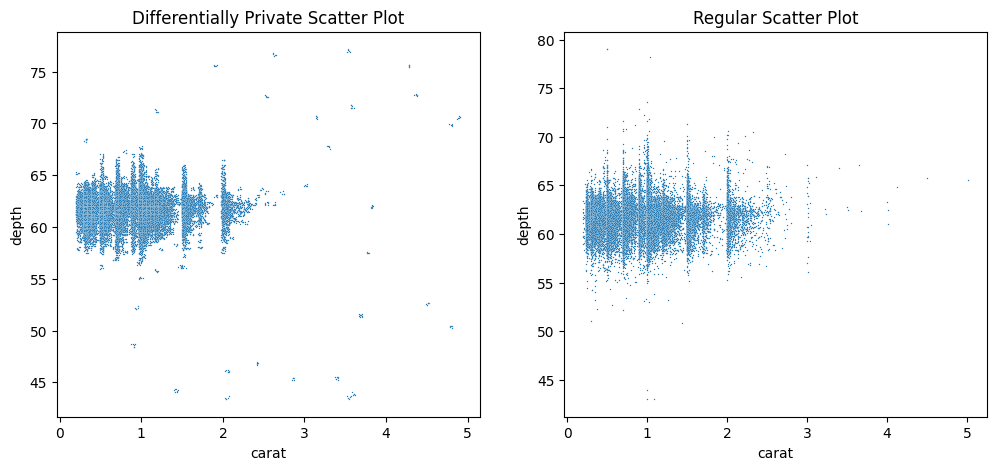

In [ ]:
import seaborn as sns
import pandas as pd

# we want to compare DP vs Non-DP scatterplot for the same dataset
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sns.scatterplot(x=pd.Series(x), y=pd.Series(y), s=1, ax=ax1)
ax1.set_xlabel(col_names[0])
ax1.set_ylabel(col_names[1])
ax1.set_title("Differentially Private Scatter Plot")
train_X = sns.load_dataset('diamonds')
sns.scatterplot(x=col_names[0], y=col_names[1], data=train_X, s=1, ax=ax2)
ax2.set_title("Regular Scatter Plot")

## Applying Concepts in Unusual Ways

With only the the Laplace mechanism and the concept of parrellel composition we can already do a lot of interesting things.

In the example below we take the concept of parrellel composition to an extreme by applying the Laplace mechanism to individual datapoints. This is known as local differential privacy.

Imagine we are interested in analysing people queuing in an airport. We want to hide the exact position of each person but maintain some global trends. In this case we would need to hide both the exact position of a person and their output.

Assuming the length of the queue is a fixed length, one way to hide the exact ordering is to take each persons is to simply apply Laplacian noise to each persons position, then reorder the queue based on the "noisy" ordering of the randomized queue.

We can visualize this by creating a colour spectrum and reordering it with different levels of epsilon, from tiny to large.

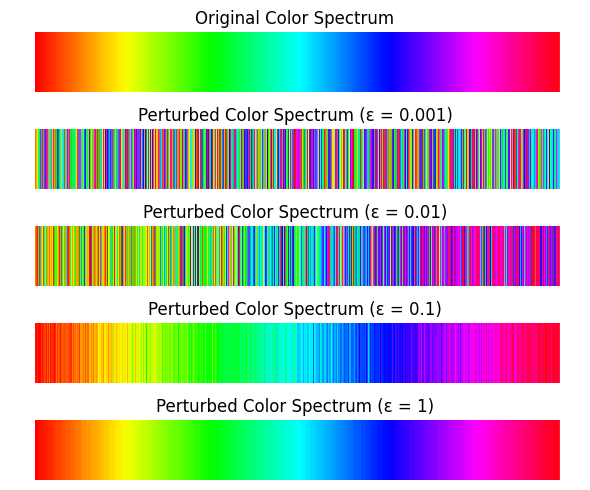

In [ ]:
# This is not safe DP, use only for illustration purposes
# Varying levels of epsilon and observing the effects on the perturbation of the color spectrum
import numpy as np
import matplotlib.pyplot as plt


# Set seed for reproducibility
np.random.seed(42)

n = 1000  # number of data points

# Correcting the application of Laplace noise for positions
original_positions = np.arange(n)  # Adjusted to match length of original_classes

# Generating a color spectrum as a linspace through HSV color space and converting it to RGB
n_colors = 1000  # Number of colors in the spectrum
colors_hsv = np.vstack([np.linspace(0, 1, n_colors), np.ones(n_colors), np.ones(n_colors)]).T
colors_rgb = plt.cm.hsv(colors_hsv[:,0])


# Epsilon values in powers of 10 from 0.001 to 1
epsilon_values = [0.001, 0.01, 0.1, 1]
fig, axes = plt.subplots(len(epsilon_values) + 1, 1, figsize=(6, (len(epsilon_values) + 1)), sharex=True)

# Plot the original spectrum first
for pos, color in enumerate(colors_rgb):
    axes[0].axvline(x=pos, color=color, linewidth=2)
axes[0].set_title("Original Color Spectrum")
axes[0].axis('off')

# Apply and plot perturbed spectra for each epsilon value
for i, eps in enumerate(epsilon_values, start=1):
    epsilon_split = eps / 2  # Assuming split of epsilon for simplicity
    perturbed_positions = original_positions + np.random.laplace(0, 1/epsilon_split, n_colors)
    sorted_indices = np.argsort(perturbed_positions)

    for pos, color in enumerate(colors_rgb[sorted_indices]):
        axes[i].axvline(x=pos, color=color, linewidth=2)
    axes[i].set_title(f"Perturbed Color Spectrum (ε = {eps})")
    axes[i].axis('off')

plt.tight_layout()
plt.show()


While this was only a quick tour of differential privacy, considering only a single mechanism, hopefully it gave you an intuition into the domain.

AGENT takes advantage of the Laplace mechanism and parrellel composition, along with other mechanisms such as the binary mechanism, the exponential mechanism, the Gausian mechanism and more - all under the hood, so you can focus on analysis and benefit from privacy by default.